In [1]:
# import packages
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
import seaborn as sns 
import numpy as np
import os
import glob

### Mock data

In [2]:
std = pd.read_excel('input/mock_standard.xlsx')
# remove space at the end of species names
std['Species'] = std['Species'].str.strip()
std.head(2)

,Species,std_abundance
0,Faecalibacterium prausnitzii,14.77
1,Veillonella rogosae,19.94


In [5]:
# Metaplan
tax = pd.read_csv('input/mock_Metaplan.txt', sep='\t', names=["clade_name", "NCBI_tax_id",
                   "metaplane_abundance", "additional_species"], skiprows=4)

taxU = tax[tax['clade_name'].str.contains("s__")].copy()  
newR = taxU['clade_name'].str.split(pat='s__', expand=True)
taxU.loc[:, 'Species'] = newR[1].values  

data = taxU[['Species', 'metaplane_abundance']]

# change '_' to ' ' in species names
data['Species'] = data['Species'].str.replace('_', ' ')
# remove space at the end of species names
data['Species'] = data['Species'].str.rstrip()

mrg_met = pd.merge(data, std, on='Species', how='outer')

# if metaplane_abundance & std_abundance not null add value present in new column 'status'
mrg_met['status'] = mrg_met.apply(lambda x: 'detected' if pd.notnull(x['metaplane_abundance']) and pd.notnull(x['std_abundance']) else '', axis=1)
mrg_met['status'] = mrg_met.apply(lambda x: 'false positive' if pd.notnull(x['metaplane_abundance']) and pd.isnull(x['std_abundance']) else x['status'], axis=1)
mrg_met['status'] = mrg_met.apply(lambda x: 'not detected' if pd.isnull(x['metaplane_abundance']) and pd.notnull(x['std_abundance']) else x['status'], axis=1)

# add new column abundane. if metaplane_abundance & std_abundance not null fill it with std_abundance value
mrg_met['abundance'] = mrg_met.apply(lambda x: x['std_abundance'] if pd.notnull(x['std_abundance']) else x['metaplane_abundance'], axis=1)

mrg_met.to_excel('results/mock_metaphlan.xlsx', index=False)
mrg_met.head(2)


/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_34071/1745382223.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Species'] = data['Species'].str.replace('_', ' ')
/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_34071/1745382223.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Species'] = data['Species'].str.rstrip()


,Species,metaplane_abundance,std_abundance,status,abundance
0,Bacteroides fragilis,20.46364,8.33,detected,8.33
1,Escherichia coli,18.90745,8.71,detected,8.71


In [14]:
# Karaken + Braken
bra = pd.read_csv('input/mock.bracken', sep='\t')
# change column name 'name' to 'Species'
bra = bra.rename(columns={'name':'Species'})

mrg_bra = pd.merge(bra, std, on='Species', how='outer').sort_values(by='std_abundance')

# if metaplane_abundance & std_abundance not null add value present in new column 'status'
mrg_bra['status'] = mrg_bra.apply(lambda x: 'detected' if pd.notnull(x['fraction_total_reads']) and pd.notnull(x['std_abundance']) else '', axis=1)
mrg_bra['status'] = mrg_bra.apply(lambda x: 'false positive' if pd.notnull(x['fraction_total_reads']) and pd.isnull(x['std_abundance']) else x['status'], axis=1)
mrg_bra['status'] = mrg_bra.apply(lambda x: 'not detected' if pd.isnull(x['fraction_total_reads']) and pd.notnull(x['std_abundance']) else x['status'], axis=1)

# add new column abundane. if metaplane_abundance & std_abundance not null fill it with std_abundance value
mrg_bra['abundance'] = mrg_bra.apply(lambda x: x['std_abundance'] if pd.notnull(x['std_abundance']) else x['fraction_total_reads'], axis=1)

mrg_bra.to_excel('results/mock_braken.xlsx', index=False)
mrg_bra.head(3)

,Species,taxonomy_id,taxonomy_lvl,kraken_assigned_reads,added_reads,new_est_reads,fraction_total_reads,std_abundance,status,abundance
3049,Clostridium perfringens,NaN,NaN,NaN,NaN,NaN,NaN,0.00009,not detected,0.00009
2655,Enterococcus faecalis,48771.0,S,139.0,5.0,144.0,0.00001,0.00110,detected,0.00110
1892,Salmonella enterica,94937.0,S,3524.0,276.0,3800.0,0.00021,0.00700,detected,0.00700


In [16]:
# mOTUs
motus = pd.read_csv('input/mock.motus', sep='\t')
motus = motus[motus['unnamed sample'] > 0]
# slpit column by [
motus['Species'] = motus['consensus_taxonomy'].str.split('[').str[0]
motus = motus[['Species', 'unnamed sample']]
# change column name
motus = motus.rename(columns={'unnamed sample':'motus_abundance'})
# drop space at the end of Species name
motus['Species'] = motus['Species'].str.rstrip()

mrg_motus = pd.merge(motus, std, on='Species', how='outer').sort_values(by='std_abundance')

# if metaplane_abundance & std_abundance not null add value present in new column 'status'
mrg_motus['status'] = mrg_motus.apply(lambda x: 'detected' if pd.notnull(x['motus_abundance']) and pd.notnull(x['std_abundance']) else '', axis=1)
mrg_motus['status'] = mrg_motus.apply(lambda x: 'false positive' if pd.notnull(x['motus_abundance']) and pd.isnull(x['std_abundance']) else x['status'], axis=1)
mrg_motus['status'] = mrg_motus.apply(lambda x: 'not detected' if pd.isnull(x['motus_abundance']) and pd.notnull(x['std_abundance']) else x['status'], axis=1)

# add new column abundane. if metaplane_abundance & std_abundance not null fill it with std_abundance value
mrg_motus['abundance'] = mrg_motus.apply(lambda x: x['std_abundance'] if pd.notnull(x['std_abundance']) else x['motus_abundance'], axis=1)

mrg_motus.to_excel('results/mock_motus.xlsx', index=False)
motus.head(3)

,Species,motus_abundance
93,Escherichia coli,0.136332
97,Salmonella enterica,0.000466
714,Clostridioides difficile,0.023751


/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_34071/958129859.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=mrg_met, y='abundance', x='status', palette='Set2')


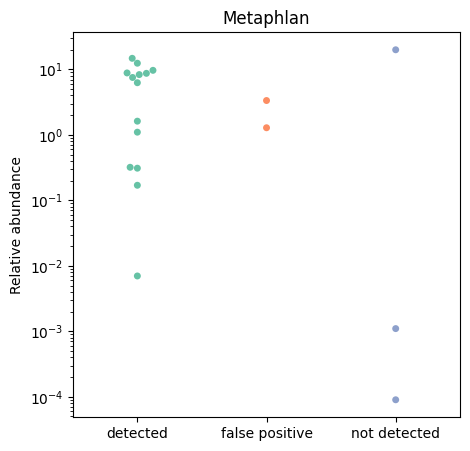

In [7]:
# fig size
plt.figure(figsize=(5, 5))

plt.yscale("log")
sns.swarmplot(data=mrg_met, y='abundance', x='status', palette='Set2')
plt.title('Metaphlan')
plt.ylabel('Relative abundance')
plt.xlabel('')

plt.savefig('results/Metaphlan.png', dpi=300, bbox_inches='tight')

/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_34071/855244724.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=mrg_bra, y='abundance', x='status', palette='Set2')
/Users/katerynapantiukh/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/katerynapantiukh/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 89.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/katerynapantiukh/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3544: UserWarning: 91.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


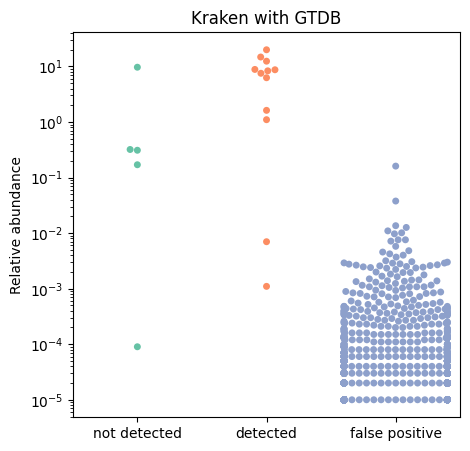

In [10]:
# fig size
plt.figure(figsize=(5, 5))

plt.yscale("log")
sns.swarmplot(data=mrg_bra, y='abundance', x='status', palette='Set2')
plt.title('Kraken with GTDB')
plt.ylabel('Relative abundance')
plt.xlabel('')

plt.savefig('results/Kraken.png', dpi=300, bbox_inches='tight')

/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_34071/827681504.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=mrg_motus, y='abundance', x='status', palette='Set2')


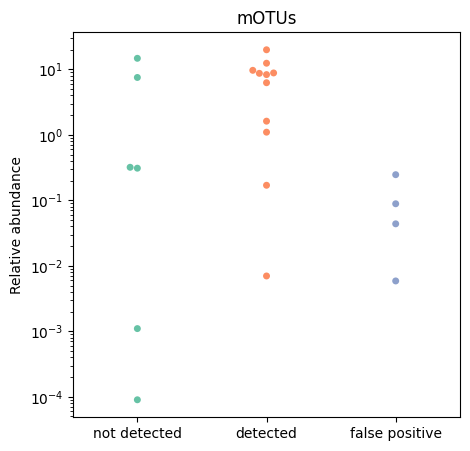

In [17]:
# fig size
plt.figure(figsize=(5, 5))

plt.yscale("log")
sns.swarmplot(data=mrg_motus, y='abundance', x='status', palette='Set2')
plt.title('mOTUs')
plt.ylabel('Relative abundance')
plt.xlabel('')

plt.savefig('results/mOTUs.png', dpi=300, bbox_inches='tight')
plt.savefig('results/mOTUs.svg', bbox_inches='tight')

### Regular plots

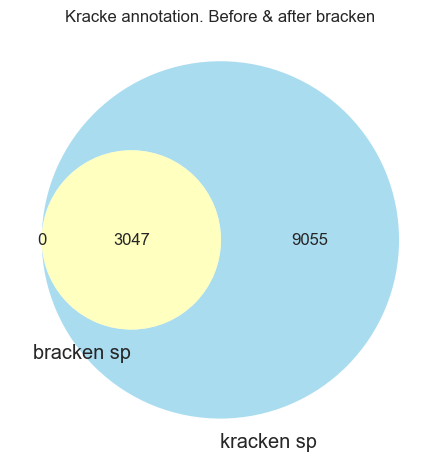

In [81]:
from matplotlib_venn import venn2

venn2([set(bra['name'].to_list()), 
       set(krep['name'].to_list())],
       set_labels=('bracken sp', 'kracken sp'), 
       set_colors=('orange', 'skyblue'), alpha = 0.7)

plt.title('Kracke annotation. Before & after bracken')
plt.tight_layout()
plt.savefig('results/kra_vs_bra.svg')